# **Automatidata project**
**Course 6 - The Nuts and bolts of machine learning**

You are a data professional in a data analytics firm called Automatidata. Their client, the New York City Taxi & Limousine Commission (New York City TLC), was impressed with the work you have done and has requested that you build a machine learning model to predict if a customer will not leave a tip. They want to use the model in an app that will alert taxi drivers to customers who are unlikely to tip, since drivers depend on tips.

A notebook was structured and prepared to help you in this project. Please complete the following questions.

# Course 6 End-of-course project: Build a machine learning model

In this activity, you will practice using tree-based modeling techniques to predict on a binary target class.  
<br/>   

**The purpose** of this model is to find ways to generate more revenue for taxi cab drivers.  
  
**The goal** of this model is to predict whether or not a customer is a generous tipper.  
<br/>  

*This activity has three parts:*

**Part 1:** Ethical considerations 
* Consider the ethical implications of the request 

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps

Follow the instructions and answer the questions below to complete the activity. Then, complete an Executive Summary using the questions listed on the PACE Strategy Document. 

Be sure to complete this activity before moving on. The next course item will provide you with a completed exemplar to compare to your own work. 



# Build a machine learning model

<img src="images/Pace.png" width="100" height="100" align=left>

# **PACE stages**


Throughout these project notebooks, you'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

<img src="images/Plan.png" width="100" height="100" align=left>


## PACE: Plan 

Consider the questions in your PACE Strategy Document to reflect on the Plan stage.

In this stage, consider the following questions:

1.   What are you being asked to do?


2.   What are the ethical implications of the model? What are the consequences of your model making errors?
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a customer will give a tip, but they actually won't)?
  
  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a customer will not give a tip, but they actually will)?  
  
  
3.   Do the benefits of such a model outweigh the potential problems?
  
4.   Would you proceed with the request to build this model? Why or why not?
 
5.   Can the objective be modified to make it less problematic?
 


==> ENTER YOUR RESPONSES TO QUESTIONS 1-5 HERE

Suppose you were to modify the modeling objective so, instead of predicting people who won't tip at all, you predicted people who are particularly generous&mdash;those who will tip 20% or more? Consider the following questions:

1.  What features do you need to make this prediction?

2.  What would be the target variable?  

3.  What metric should you use to evaluate your model? Do you have enough information to decide this now?


==> ENTER YOUR RESPONSES TO QUESTIONS 1-3 HERE


**_Complete the following steps to begin:_**

### **Task 1. Imports and data loading**

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance 
from xgboost import plot_importance

In [ ]:
# RUN THIS CELL TO SEE ALL COLUMNS 
# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

Begin by reading in the data. There are two dataframes: one containing the original data, the other containing the mean durations, mean distances, and predicted fares from the previous course's project called nyc_preds_means.csv.

**Note:** `Pandas` reads in the dataset as `df0`, now inspect the first five rows. As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [ ]:
# RUN THE CELL BELOW TO IMPORT YOUR DATA. 

# Load dataset into dataframe
df0 = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')

# Import predicted fares and mean distance and duration from previous course
nyc_preds_means = pd.read_csv('nyc_preds_means.csv')

Inspect the first few rows of `df0`.


In [ ]:
# Inspect the first few rows of df0
### YOUR CODE HERE ###
df0.head(10)

Inspect the first few rows of `nyc_preds_means`.

In [ ]:
# Inspect the first few rows of `nyc_preds_means`
### YOUR CODE HERE ###
nyc_preds_means.head(10)

#### Join the two dataframes

Join the two dataframes using a method of your choice.

In [ ]:
# Merge datasets
#gonna just use merge and merge on right
# Merge datasets
df0 = df0.merge(nyc_preds_means,
                left_index=True,
                right_index=True)

df0.head()
### YOUR CODE HERE ###
#not sure where its merging, since left and right index just mean that it stays in the same location. Might not be the same values??

<img src="images/Analyze.png" width="100" height="100" align=left>

## PACE: **Analyze**

Consider the questions in your PACE Strategy Documentto reflect on the Analyze stage.

### **Task 2. Feature engineering**

You have already prepared much of this data and performed exploratory data analysis (EDA) in previous courses. 

Call `info()` on the new combined dataframe.

In [ ]:
#==> ENTER YOUR CODE HERE
df0.info()

You know from your EDA that customers who pay cash generally have a tip amount of $0. To meet the modeling objective, you'll need to sample the data to select only the customers who pay with credit card. 

Copy `df0` and assign the result to a variable called `df1`. Then, use a Boolean mask to filter `df1` so it contains only customers who paid with credit card.

In [ ]:
# Subset the data to isolate only customers who paid by credit card
#==> ENTER YOUR CODE HERE
# df0['payment_type'].unique()
#had to check with old code to determine what the credit card value was
df1 = df0[df0['payment_type'] == 1]
# df1 = df0[df0['payment_type']]

##### **Target**

Notice that there isn't a column that indicates tip percent, which is what you need to create the target variable. You'll have to engineer it. 

Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

Round the result to three places beyond the decimal. **This is an important step.** It affects how many customers are labeled as generous tippers. In fact, without performing this step, approximately 1,800 people who do tip ≥ 20% would be labeled as not generous. 

To understand why, you must consider how floats work. Computers make their calculations using floating-point arithmetic (hence the word "float"). Floating-point arithmetic is a system that allows computers to express both very large numbers and very small numbers with a high degree of precision, encoded in binary. However, precision is limited by the number of bits used to represent a number, which is generally 32 or 64, depending on the capabilities of your operating system. 

This comes with limitations in that sometimes calculations that should result in clean, precise values end up being encoded as very long decimals. Take, for example, the following calculation:


In [ ]:
# Run this cell
1.1 + 2.2

Notice the three that is 16 places to the right of the decimal. As a consequence, if you were to then have a step in your code that identifies values ≤ 3.3, this would not be included in the result. Therefore, whenever you perform a calculation to compute a number that is then used to make an important decision or filtration, round the number. How many degrees of precision you round to is your decision, which should be based on your use case. 

Refer to this [guide for more information related to floating-point arithmetic](https://floating-point-gui.de/formats/fp/).  
Refer to this [guide for more information related to fixed-point arithmetic](https://inst.eecs.berkeley.edu/~cs61c/sp06/handout/fixedpt.html), which is an alternative to floating-point arithmetic used in certain cases.

In [ ]:
# Create tip % col
# Create tip % col
df1.columns
df1['tip_percent'] = round(df1['tip_amount']/(df1['total_amount'] - df1['tip_amount']), 3)
df1.head(10)
#==> ENTER YOUR CODE HERE

Now create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [ ]:
# Create 'generous' col (target)

df1['generous'] = df1['tip_percent']
df1['generous'] = (df1['generous'] >= 0.2)
df1['generous'] = df1['generous'].astype(int)
#==> ENTER YOUR CODE HERE

<details>
  <summary><h5>HINT</h5></summary>

To convert from Boolean to binary, use `.astype(int)` on the column.
</details>

#### Create day column

Next, you're going to be working with the pickup and dropoff columns.

Convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime.

In [ ]:
# Convert pickup and dropoff cols to datetime
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'])
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'])
#==> ENTER YOUR CODE HERE

Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [ ]:
# Create a 'day' col
df1['day'] = df1['tpep_pickup_datetime'].dt.day_name().str.lower()
#==> ENTER YOUR CODE HERE


<details>
  <summary><h5>HINT</h5></summary>

To convert to day name, use `dt.day_name()` on the column.
</details>

#### Create time of day columns

Next, engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

`am_rush` = [06:00&ndash;10:00)  
`daytime` = [10:00&ndash;16:00)  
`pm_rush` = [16:00&ndash;20:00)  
`nighttime` = [20:00&ndash;06:00)  

To do this, first create the four columns. For now, each new column should be identical and contain the same information: the hour (only) from the `tpep_pickup_datetime` column.

In [ ]:
# Create 'am_rush' col
#==> ENTER YOUR CODE HERE
df1['am_rush'] = df1['tpep_pickup_datetime'].dt.hour
# Create 'daytime' col
#==> ENTER YOUR CODE HERE
df1['daytime'] = df1['tpep_pickup_datetime'].dt.hour
# Create 'pm_rush' col
#==> ENTER YOUR CODE HERE
df1['pm_rush'] = df1['tpep_pickup_datetime'].dt.hour
# Create 'nighttime' col
df1['nighttime'] = df1['tpep_pickup_datetime'].dt.hour
df1.head(10)
#==> ENTER YOUR CODE HERE

You'll need to write four functions to convert each new column to binary (0/1). Begin with `am_rush`. Complete the function so if the hour is between [06:00–10:00), it returns 1, otherwise, it returns 0.

In [ ]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
#     temp = hour['am_rush']
    if hour['am_rush'] >= 6 and hour['am_rush'] < 10:
        return 1
    else:
        return 0
    #==> ENTER YOUR CODE HERE

Now, apply the `am_rush()` function to the `am_rush` series to perform the conversion. Print the first five values of the column to make sure it did what you expected it to do.

**Note:** Be careful! If you run this cell twice, the function will be reapplied and the values will all be changed to 0.

In [ ]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['am_rush'].head()
#==> ENTER YOUR CODE HERE

Write functions to convert the three remaining columns and apply them to their respective series.

In [ ]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if hour['daytime'] >= 10 and hour['daytime'] < 16:
        return 1
    else:
        return 0
#==> ENTER YOUR CODE HERE

In [ ]:
# Apply 'daytime()' function to the 'daytime' series
df1['daytime'] = df1.apply(daytime, axis=1)
df1['daytime'].head(5)
#==> ENTER YOUR CODE HERE

In [ ]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if hour['pm_rush'] >= 16 and hour['pm_rush'] < 20:
        return 1
    else:
        return 0
#==> ENTER YOUR CODE HERE

In [ ]:
# Apply 'pm_rush()' function to the 'pm_rush' series
df1['pm_rush'] = df1.apply(pm_rush, axis=1)
df1['pm_rush'].head(5)
#==> ENTER YOUR CODE HERE

In [ ]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if hour['nighttime'] >= 20:
        return 1
    elif hour['nighttime'] < 6:
        return 1
    else:
        return 0
#==> ENTER YOUR CODE HERE

In [ ]:
# Apply 'nighttime' function to the 'nighttime' series
df1['nighttime'] = df1.apply(nighttime, axis=1)
df1['nighttime'].head(5)
#==> ENTER YOUR CODE HERE

#### Create `month` column

Now, create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

<details>
  <summary><h5>HINT</h5></summary>

Refer to the [strftime cheatsheet](https://strftime.org/) for help.
</details>

In [ ]:
# Create 'month' col
df1['month'] = df1['tpep_pickup_datetime'].dt.month
#==> ENTER YOUR CODE HERE

Examine the first five rows of your dataframe.

In [ ]:
#==> ENTER YOUR CODE HERE
df1.head(5)

#### Drop columns

Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (`generous`) must remain in the data because it will get isolated as the `y` data for modeling.

In [ ]:
# Drop columns
#==> ENTER YOUR CODE HERE

drop = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']
df1 = df1.drop(drop, axis=1)
df1.info()

#### Variable encoding

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, you'll first need to convert them to `type(str)`. 

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_str` to string.


In [ ]:
# 1. Define list of cols to convert to string
#==> ENTER YOUR CODE HERE
cols_to_str = ['RatecodeID', 'PULocationID','DOLocationID']

# 2. Convert each column to string
#==> ENTER YOUR CODE HERE
for col in cols_to_str:
    df1[col] = df1[col].astype(str)


<details>
  <summary><h5>HINT</h5></summary>

To convert to string, use `astype(str)` on the column.
</details>

Now convert all the categorical columns to binary.

1. Call `get_dummies()` on the dataframe and assign the results back to a new dataframe called `df2`.


In [ ]:
df1.dtypes

In [ ]:
# Convert categoricals to binary
df2 = pd.get_dummies(df1, drop_first = True)
df2.head(5)
#==> ENTER YOUR CODE HERE

##### Evaluation metric

Before modeling, you must decide on an evaluation metric. 

1. Examine the class balance of your target variable. 

In [ ]:
# Get class balance of 'generous' col
df2['generous'].value_counts(normalize=True)
#==> ENTER YOUR CODE HERE

In [ ]:
df2['generous'].value_counts()


A little over half of the customers in this dataset were "generous" (tipped ≥ 20%). The dataset is very nearly balanced.

To determine a metric, consider the cost of both kinds of model error:
* False positives (the model predicts a tip ≥ 20%, but the customer does not give one)
* False negatives (the model predicts a tip < 20%, but the customer gives more)

False positives are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

False negatives are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more&mdash;even when the original customer would have tipped generously.

**The stakes are relatively even. You want to help taxi drivers make more money, but you don't want this to anger customers. Your metric should weigh both precision and recall equally. Which metric is this?**

==> ENTER YOUR RESPONSE HERE 

<img src="images/Construct.png" width="100" height="100" align=left>

## PACE: **Construct**

Consider the questions in your PACE Strategy Document to reflect on the Construct stage.

### **Task 3. Modeling**

##### **Split the data**

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/testing data. 

1. Define a variable `y` that isolates the target variable (`generous`).
2. Define a variable `X` that isolates the features.
3. Split the data into training and testing sets. Put 20% of the samples into the test set, stratify the data, and set the random state.

In [54]:
# Isolate target variable (y)
#==> ENTER YOUR CODE HERE
y = df2['generous']
X = df2.copy()
X = df2.drop('generous', axis = 1)

# Isolate the features (X)
#==> ENTER YOUR CODE HERE

# Split into train and test sets
#==> ENTER YOUR CODE HERE
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

##### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

1. Instantiate the random forest classifier `rf` and set the random state.

2. Create a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take. 
 - `max_depth`  
 - `max_features`  
 - `max_samples` 
 - `min_samples_leaf`  
 - `min_samples_split`
 - `n_estimators`  

3. Define a set `scoring` of scoring metrics for GridSearch to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `rf1`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of you cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`)


**Note:** `refit` should be set to `'f1'`.<font/>
</details>
 


In [58]:
# 1. Instantiate the random forest classifier
#==> ENTER YOUR CODE HERE
rf = RandomForestClassifier(random_state = 42)
# 2. Create a dictionary of hyperparameters to tune 
#==> ENTER YOUR CODE HERE
cv_params = {
    'max_depth' : [100],
    'max_features' : [1.0],
    'max_samples' : [0.6],
    'min_samples_leaf' : [10],
    'n_estimators' : [50]
}
# 3. Define a set of scoring metrics to capture
#==> ENTER YOUR CODE HERE
scoring = {'accuracy', 'precision','recall','f1'}
# 4. Instantiate the GridSearchCV object
#==> ENTER YOUR CODE HERE
rf1 = GridSearchCV(rf, cv_params, scoring = scoring, cv = 5, refit = 'f1')

Now fit the model to the training data. Note that, depending on how many options you include in your search grid and the number of cross-validation folds you select, this could take a very long time&mdash;even hours. If you use 4-fold validation and include only one possible value for each hyperparameter and grow 300 trees to full depth, it should take about 5 minutes. If you add another value for GridSearch to check for, say, `min_samples_split` (so all hyperparameters now have 1 value except for `min_samples_split`, which has 2 possibilities), it would double the time to ~10 minutes. Each additional parameter would approximately double the time. 

In [59]:
%%time
rf1.fit(X_train, y_train)

CPU times: user 25.7 s, sys: 22 ms, total: 25.8 s
Wall time: 25.8 s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

<details>
  <summary><h5>HINT</h5></summary>

If you get a warning that a metric is 0 due to no predicted samples, think about how many features you're sampling with `max_features`. How many features are in the dataset? How many are likely predictive enough to give good predictions within the number of splits you've allowed (determined by the `max_depth` hyperparameter)? Consider increasing `max_features`.

</details>

If you want, use `pickle` to save your models and read them back in. This can be particularly helpful when performing a search over many possible hyperparameter values.

In [60]:
import pickle 

# Define a path to the folder where you want to save the model
path = '/home/jovyan/work/'

In [61]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [62]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

Examine the best average score across all the validation folds. 

In [63]:
# Examine best score
#==> ENTER YOUR CODE HERE
rf1.best_score_

0.7414946499106747

Examine the best combination of hyperparameters.

In [64]:
#==> ENTER YOUR CODE HERE
rf1.best_params_

{'max_depth': 100,
 'max_features': 1.0,
 'max_samples': 0.6,
 'min_samples_leaf': 10,
 'n_estimators': 50}

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

<details>
  <summary><h5>HINT</h5></summary>

To learn more about how this function accesses the cross-validation results, refer to the [`GridSearchCV` scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) for the `cv_results_` attribute.

</details>

In [65]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

Call `make_results()` on the GridSearch object.

In [68]:
#==> ENTER YOUR CODE HERE
results = make_results('Random Forest CV', rf1, 'f1')
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.690663,0.800559,0.741495,0.706189


Your results should produce an acceptable model across the board. Typically scores of 0.65 or better are considered acceptable, but this is always dependent on your use case. Optional: try to improve the scores. It's worth trying, especially to practice searching over different hyperparameters.

<details>
  <summary><h5>HINT</h5></summary>

For example, if the available values for `min_samples_split` were [2, 3, 4] and GridSearch identified the best value as 4, consider trying [4, 5, 6] this time.
</details>

Use your model to predict on the test data. Assign the results to a variable called `rf_preds`.

<details>
  <summary><h5>HINT</h5></summary>
    
You cannot call `predict()` on the GridSearchCV object directly. You must call it on the `best_estimator_`.
</details>

For this project, you will use several models to predict on the test data. Remember that this decision comes with a trade-off. What is the benefit of this? What is the drawback?

==> ENTER YOUR RESPONSE HERE

In [69]:
# Get scores on test data
#==> ENTER YOUR CODE HERE
rf_preds = rf1.best_estimator_.predict(X_test)

Use the below `get_test_scores()` function you will use to output the scores of the model on the test data.

In [70]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
    model_name (string): Your choice: how the model will be named in the output table
    preds: numpy array of test predictions
    y_test_data: numpy array of y_test data

    Out:
    table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy]
                        })

    return table

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `rf_test_scores`.
2. Call `rf_test_scores` to output the results.

###### RF test results

In [71]:
 # Get scores on test data
#==> ENTER YOUR CODE HERE
rf_test_scores = get_test_scores('RF test', rf_preds, y_test)
results = pd.concat([results, rf_test_scores],axis = 0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.690663,0.800559,0.741495,0.706189
0,RF test,0.684461,0.805849,0.740211,0.702260


**Question:** How do your test results compare to your validation results?

It looks like all my scores increased slightly. If I wanted to raise it more, I would add more estimators and more bounds, but this laptop takes forever doing that so for the sake of everyone's time I won't be running a super long model.

##### **XGBoost**

 Try to improve your scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`

3. Define a set `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and accuracy).

4. Instantiate the `GridSearchCV` object `xgb1`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='f1'`)

In [74]:
# 1. Instantiate the XGBoost classifier
#==> ENTER YOUR CODE HERE
xgb = XGBClassifier(objectives ='binary:logistic', random_state = 0)
# 2. Create a dictionary of hyperparameters to tune
#==> ENTER YOUR CODE HERE
cv_params = {'learning_rate': [0.1],
             'max_depth': [8],
             'min_child_weight': [2],
             'n_estimators': [100]
             }
# 3. Define a set of scoring metrics to capture
#==> ENTER YOUR CODE HERE
scoring = {'accuracy', 'precision', 'recall', 'f1'}
# 4. Instantiate the GridSearchCV object
#==> ENTER YOUR CODE HERE
xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='f1')

Now fit the model to the `X_train` and `y_train` data.

In [75]:
%%time
xgb1.fit(X_train, y_train)

[20:29:02] WARNING: ../src/learner.cc:627: 
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:32:36] WARNING: ../src/learner.cc:627: 
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:35:19] WARNING: ../src/learner.cc:627: 
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

GridSearchCV(cv=4, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     objectives='binary:logistic',
                                     predictor=None, random_state=0, ...),
             i

Get the best score from this model.

In [76]:
# Examine best score
#==> ENTER YOUR CODE HERE
xgb1.best_score_

0.7328114946201132

And the best parameters.

In [77]:
# Examine best parameters
#==> ENTER YOUR CODE HERE
xgb1.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'min_child_weight': 2,
 'n_estimators': 100}

In [83]:
filename = 'finalized_model.sav'
pickle.dump(xgb1, open(filename, 'wb'))

##### XGB CV Results

Use the `make_results()` function to output all of the scores of your model. Note that it accepts three arguments. 

In [78]:
# Call 'make_results()' on the GridSearch object
#==> ENTER YOUR CODE HERE
xgb1_cv_results = make_results('XGB CV', xgb1, 'f1')
results = pd.concat([results, xgb1_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.690663,0.800559,0.741495,0.706189
0,RF test,0.684461,0.805849,0.740211,0.702260
0,XGB CV,0.689042,0.782670,0.732811,0.699640


Use your model to predict on the test data. Assign the results to a variable called `xgb_preds`.

<details>
  <summary><h5>HINT</h5></summary>
    
You cannot call `predict()` on the GridSearchCV object directly. You must call it on the `best_estimator_`.
</details>

In [79]:
# Get scores on test data
#==> ENTER YOUR CODE HERE
xgb_preds = xgb1.best_estimator_.predict(X_test)

###### XGB test results

1. Use the `get_test_scores()` function to generate the scores on the test data. Assign the results to `xgb_test_scores`.
2. Call `xgb_test_scores` to output the results.

In [80]:
# Get scores on test data
#==> ENTER YOUR CODE HERE
xgb_test_scores = get_test_scores('XGB test', xgb_preds, y_test)
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest CV,0.690663,0.800559,0.741495,0.706189
0,RF test,0.684461,0.805849,0.740211,0.702260
0,XGB CV,0.689042,0.782670,0.732811,0.699640
0,XGB test,0.686670,0.804605,0.740974,0.703898


**Question:** Compare these scores to the random forest test scores. What do you notice? Which model would you choose?

You should plot a confusion matrix for the test data. 

Plot a confusion matrix of the model's predictions on the test data.

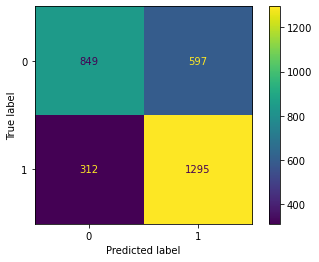

In [81]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels=rf1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf1.classes_, 
                             )
disp.plot(values_format='');

**Question:** What type of errors are more common for your model?

The odel will have issues with false positives compared to false negatives. Type I errors are more common.

##### Feature importance

Use the `feature_importances_` attribute of the best estimator object to inspect the features of your final model. You can then sort them and plot the most important ones.

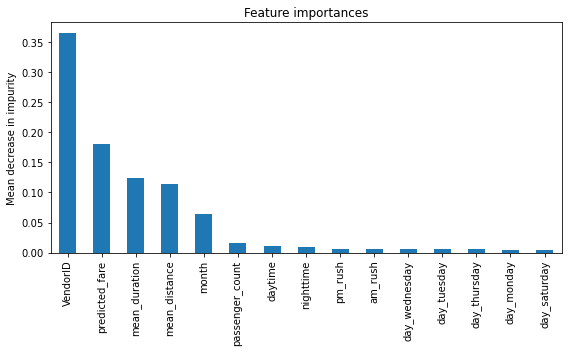

In [82]:
importances = rf1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)
rf_importances = rf_importances.sort_values(ascending=False)[:15]

fig, ax = plt.subplots(figsize=(8,5))
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout();

<img src="images/Execute.png" width="100" height="100" align=left>

## PACE: **Execute**

Consider the questions in your PACE Strategy Document to reflect on the Execute stage.

### **Task 4. Conclusion**

In this step, use the results of the models above to formulate a conclusion. Consider the following questions:

1. **Would you recommend using this model? Why or why not?**  

2. **What was your model doing? Can you explain how it was making predictions?**   

3. **Are there new features that you can engineer that might improve model performance?**   

4. **What features would you want to have that would likely improve the performance of your model?**   

Remember, sometimes your data simply will not be predictive of your chosen target. This is common. Machine learning is a powerful tool, but it is not magic. If your data does not contain predictive signal, even the most complex algorithm will not be able to deliver consistent and accurate predictions. Do not be afraid to draw this conclusion. Even if you cannot use the model to make strong predictions, was the work done in vain? Consider any insights that you could report back to stakeholders.

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.

In [84]:
#This model took way too long to train, nearly thrity minutes.
#if someone uses my model, it would be better then just a random model purely because
#I'd alraedy went through the annoying part and it is generally accurate.

In [85]:
#This is a random forest model, which is a type of black box model, We'd need to
#investigate exactly what is happening internally more, but it is above my paygrade.

In [86]:
#Multiple additional features can be engineered.

In [87]:
#customer data would easily be the best, since there might be certain customers skewing the data in one way or another.